In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon
    
latent_dim = 8

# ENCODER
T = 4320
encoder_inputs = keras.Input(shape=(T, 1))  # 1D sequence, single channel
x = layers.Conv1D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv1D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

encoder.summary()

# DECODER
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense((T // 4) * 64, activation="relu")(latent_inputs)  # match downsampling in encoder
x = layers.Reshape((T // 4, 64))(x)
x = layers.UpSampling1D(2)(x)
x = layers.Conv1D(64, 3, activation="relu", padding="same")(x)
x = layers.UpSampling1D(2)(x)
x = layers.Conv1D(32, 3, activation="relu", padding="same")(x)
decoder_outputs = layers.Conv1D(1, 3, activation="linear", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

decoder.summary()


2025-10-05 17:40:52.267215: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-05 17:40:52.268443: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-05 17:40:52.393048: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-05 17:40:54.410233: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 4320, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 2160, 32)  │        128 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1080, 64)  │      6,208 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 69120)     │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │  8,847,488 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 8)         │      1,032 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 8)         │      1,032 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 8)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,855,888 (33.78 MB)

 Trainable params: 8,855,888 (33.78 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 69120)          │       622,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1080, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 2160, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 2160, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 4320, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 4320, 32)       │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 4320, 1)        │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 640,705 (2.44 MB)

 Trainable params: 640,705 (2.44 MB)

 Non-trainable params: 0 (0.00 B)

In [2]:
# --- VAE Model ---
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        noisy, clean = data  # unpack tuple (noisy input, clean target)
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(noisy)
            reconstruction = self.decoder(z)
            reconstruction_loss = ops.mean(
                ops.sum(keras.losses.mean_squared_error(clean, reconstruction), axis=1)
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [8]:
# --- Load noise dataset ---
import numpy as np
with np.load("training_data_vectorized_all.npz") as npz:
    data = npz["flux_normal"]  # shape (NUM, N)
    data_with_transits = npz["flux_with_planet"]

# Reshape for CNN (num_samples, length, channels)
X_clean = data[..., np.newaxis].astype("float32")
X_noisy = data_with_transits[..., np.newaxis].astype("float32")


In [9]:
import matplotlib.pyplot as plt
# --- Helper: plot reconstructions ---
def plot_reconstructions(model, noisy, clean, n=5):
    idxs = np.random.choice(len(noisy), n, replace=False)
    reconstructed = model.decoder(model.encoder(noisy[idxs])[2]).numpy()
    plt.figure(figsize=(15, 2 * n))
    for i, idx in enumerate(idxs):
        plt.subplot(n, 1, i + 1)
        plt.plot(noisy[idx, :, 0], label="Noisy (with transit)", alpha=1)
        plt.plot(clean[idx, :, 0], label="Target (clean star noise)", alpha=0.6)
        plt.plot(reconstructed[i, :, 0], label="Reconstructed", alpha=0.8)
        plt.legend()
    plt.tight_layout()
    plt.show()

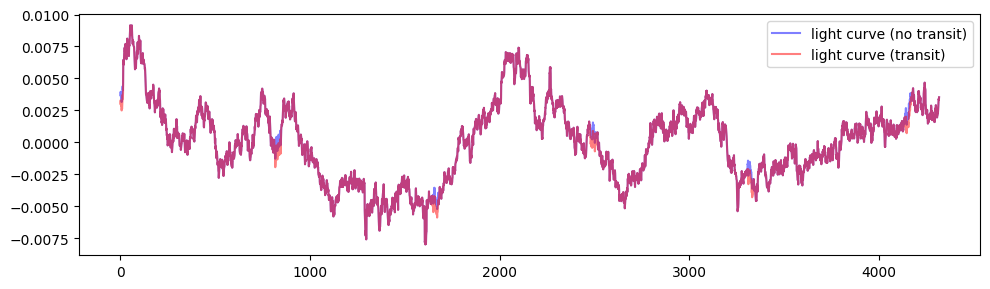

In [10]:
# look at some transits

plt.figure(figsize=(10, 3))
N = len( X_clean[10])
plt.plot(np.arange(N), X_clean[10], color='blue', alpha=0.5, label='light curve (no transit)')
plt.plot(np.arange(N), X_noisy[10], color='red', alpha=0.5, label='light curve (transit)')

#plt.scatter(np.arange(N)[planet_mask], transited_planet[planet_mask], color='red', s=6, zorder=3, label='Planet (in-transit)')
plt.legend()
plt.tight_layout()
plt.show()

# test to see transits effect

In [11]:
# --- Train ---
vae = VAE(encoder, decoder)
vae.compile(optimizer="adam")

history = vae.fit(
    X_noisy, X_clean,  # input noisy → target clean
    epochs=50,
    batch_size=128,
)

Epoch 1/50


2025-10-05 17:41:54.756847: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 464ms/step - kl_loss: 0.0387 - loss: 51.6818 - reconstruction_loss: 51.6431
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 385ms/step - kl_loss: 0.3683 - loss: 50.6117 - reconstruction_loss: 50.2435
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 451ms/step - kl_loss: 1.6422 - loss: 42.2137 - reconstruction_loss: 40.5715
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 454ms/step - kl_loss: 1.9543 - loss: 33.3550 - reconstruction_loss: 31.4008
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 395ms/step - kl_loss: 1.5445 - loss: 30.5727 - reconstruction_loss: 29.0282
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 459ms/step - kl_loss: 1.4999 - loss: 28.5246 - reconstruction_loss: 27.0246
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 461ms/step - kl_loss: 1.3437 - loss: 30.9665 - reconstruction_loss: 29.6228
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 458ms/step - kl_loss: 1.3085 - loss: 39.7856 - reconstruction_loss: 38.4770
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 373ms/step - kl_loss: 1.3046 - lo

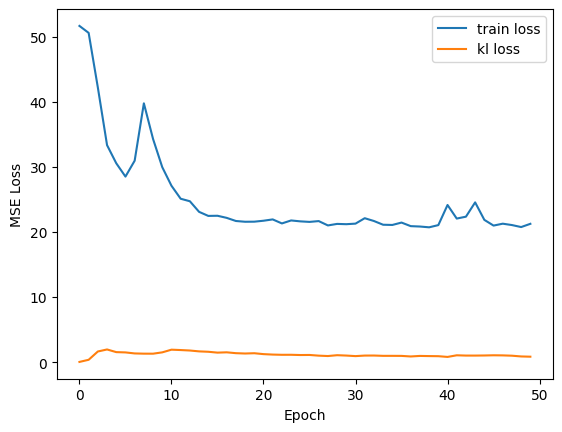

In [12]:
# Plot loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['kl_loss'], label='kl loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

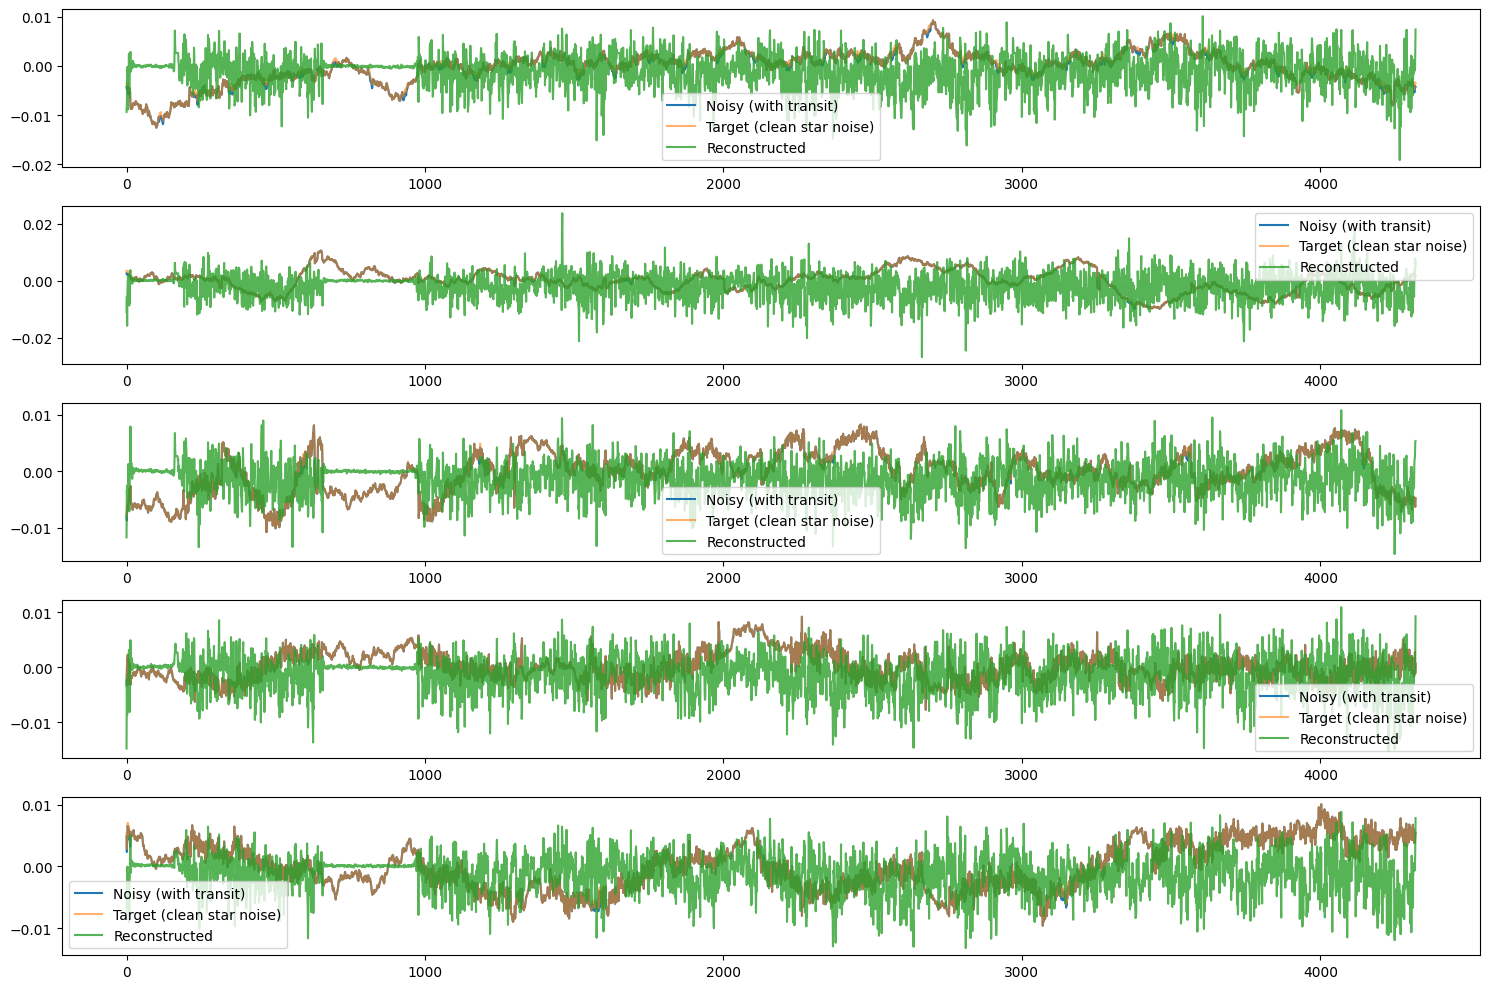

In [13]:
plot_reconstructions(vae, X_noisy, X_clean, n=5)